In [239]:
import json
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table
from scipy.io.idl import readsav
import scipy.signal as signal
from scipy.interpolate import BSpline, make_lsq_spline

if '../lib' not in sys.path:
    sys.path.append('../lib')
import snelib19odp.specsmooth as specsmooth

def load_json_specs(fname, phase0):
    with open(fname, 'r') as f:
        data = json.load(f)
    sne = data[list(data.keys())[0]]
    specs = sne['spectra']
    redshift = float(sne['redshift'][0]['value'])
    #print(specs[1])
    ret_specs = []
    for spec in specs:
        if not 'time' in spec:
            continue
        t = spec['time']
        wave = np.array([float(x[0]) for x in spec['data']])
        flux = np.array([float(x[1]) for x in spec['data']]) 
        ret_specs.append({'time': float(t), 'phase': float(t)-phase0, 'wave': wave, 'restwave': wave/(1+redshift), 'flux': flux})
    return sorted(ret_specs, key=lambda x: x['time'])

In [185]:
# load comparison objects
sn2008d_specs = load_json_specs('../data/comparison/SN2008D.json', phase0=54492)
sn1998bw = load_json_specs('../data/comparison/SN1998bw.json', phase0=50946)
#ptf13bvn = load_json_specs('../data/comparison/iPTF13bvn.json')

In [189]:
# load the observed spectra
obs_specs = []
for fname in glob.glob('../products/specs/fluxcal/*.ascii'):
    spec = table.Table.read(fname, format='ascii')
    fname = os.path.basename(fname)
    obs_specs.append((fname, spec))
obs_specs = sorted(obs_specs, key=lambda x: x[0])
#obs_specs[0]

odp_redshift = table.Table.read('../const/distance/current', format='ascii')['redshift'][0]
print('ODP Redshift: ', odp_redshift)

ODP Redshift:  0.014353


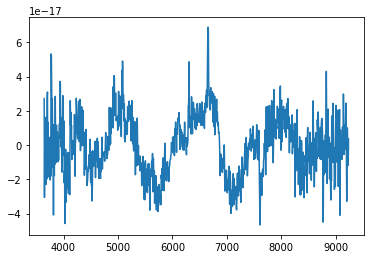

In [217]:
# function to remove some pseudo-continuum..
def remove_cont(wavelength, flux):
    #plt.plot(wavelength, flux)
    #wavelength_element = np.mean(np.diff(wavelength))
    #kernel_size = int(200/wavelength_element)+1
    #if kernel_size % 2  == 0:
    #    kernel_size += 1
    #flux_smoothed = signal.medfilt(flux, kernel_size)
    #plt.plot(wavelength, flux_smoothed)
    ## construct a smoothing spline
    # params:
    # order k
    k = 3
    
    # construct spline knot points
    if wavelength.max() > 8000:
        t = [5000, 6000, 7000, 8000]
    elif wavelength.max() > 7000:
        t = [5000, 5700, 6500]
    elif wavelength.max() > 6000:
        t = [4500, 5000, 6000]
    else:
        raise ValueError('fail')
    t = np.r_[(wavelength[0],)*(k+1),
          t,
          (wavelength[-1],)*(k+1)]
    
    # compute spline coefficients
    #spl = make_lsq_spline(wavelength, flux_smoothed, t, k)
    
    
    # and compute the spline curve
    #spline = spl(wavelength)
    #plt.plot(wavelength, spline)
    idx = ~np.isnan(flux)
    spl = make_lsq_spline(wavelength[idx], flux[idx], t, k)
    spline = spl(wavelength)
    #plt.plot(wavelength, spline)
    
    return flux - spline, spline

wave, flux = obs_specs[1][1]['wavelength'], obs_specs[1][1]['flux']
flux_flat, continuum = remove_cont(wave, flux)
plt.plot(wave, flux_flat)

#plt.plot(obs_specs[1][1]['wavelength'], remove_cont(obs_specs[1][1]['wavelength'], obs_specs[1][1]['flux']))
#plt.plot(obs_specs[0][1]['wavelength'], remove_cont(obs_specs[0][1]['wavelength'], obs_specs[0][1]['flux']))

In [245]:
def plot_spec(ax, restwave, wave, flux, label, smooth=3, rebin=None, blue_cut=3000, red_cut=9500, clip_telluric=False, offset=0.0):
    datidx = np.logical_and(wave > blue_cut, wave < red_cut)
    restwave, wave, flux = restwave[datidx], wave[datidx], flux[datidx]
    
    if clip_telluric:
        idx = np.logical_and(wave > 7580, wave < 7680)
        flux[idx] = np.nan
    
    flux_cont_removed, continuum = remove_cont(wave, flux)
    
    # smooth it a bit
    #if smooth is None:
    #    flux_smoothed = flux_cont_removed
    #else:
    #    flux_smoothed = signal.medfilt(flux_cont_removed, smooth)
    if rebin is None:
        wave_rebinned = restwave
        flux_rebinned = flux_cont_removed
    else:
        wave_rebinned = restwave[::rebin]
        flux_rebinned = specsmooth.spectres(wave_rebinned, restwave, flux_cont_removed)
    
    if smooth is None:
        flux_smoothed = flux_rebinned
    else:
        flux_smoothed = signal.medfilt(flux_rebinned, smooth)
    #print(flux_smoothed)
    flux_super_smooth = signal.medfilt(flux_cont_removed, 15)
    
    # normalize
    norm_factor = np.percentile(flux_super_smooth[~np.isnan(flux_super_smooth)], 99)
    #print(norm_factor)
    #print(restwave.shape, wave.shape, flux_smoothed.shape)
    #ax.plot(restwave, flux_smoothed/norm_factor+offset, label=label)
    ax.plot(wave_rebinned, flux_smoothed/norm_factor+offset, label=label)

def plot_obs_spec(ax, idx, **kwargs):
    fname, spec = obs_specs[idx]
    wave, flux = spec['wavelength'], spec['flux']
    restwave = wave / (1+odp_redshift)
    #print(restwave.shape, wave.shape, flux.shape)
    plot_spec(ax, restwave, wave, flux, label=fname, **kwargs)

def plot_comparison(ax, objname, idx, **kwargs):
    if objname == '08d':
        specs = sn2008d_specs
        label = 'SN2008D'
    elif objname == '98bw':
        label = 'SN1998bw'
        specs = sn1998bw
    else:
        raise ValueError('wrong comparison object')
        
    obj = specs[idx]
    restwave = obj['restwave']
    wave = obj['wave']
    flux = obj['flux']
    phase = obj['phase']
    
    plot_spec(ax, restwave, wave, flux, label='%s (phase %.1f)' % (label, phase), **kwargs)

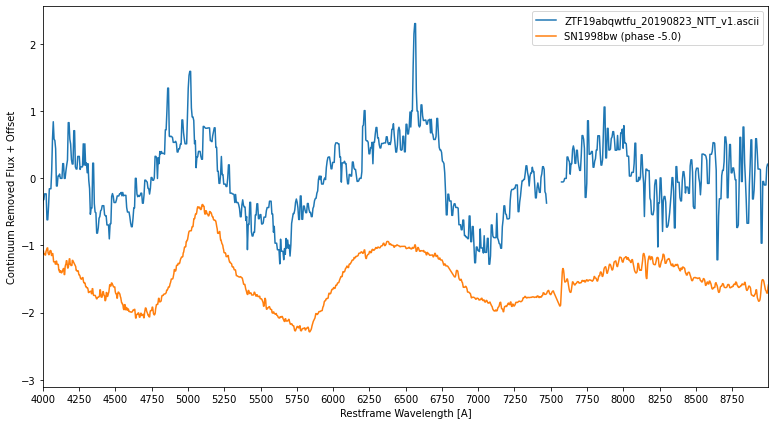

In [210]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 1, smooth=3, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '98bw', 4, offset=-1.5)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((4000, 9000))
ax.set_xticks(np.arange(4000, 9000, 250))

ax.legend()
fig.savefig('../paper/plots/specs/tmp_first_ntt_comparison_98bw.png')


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



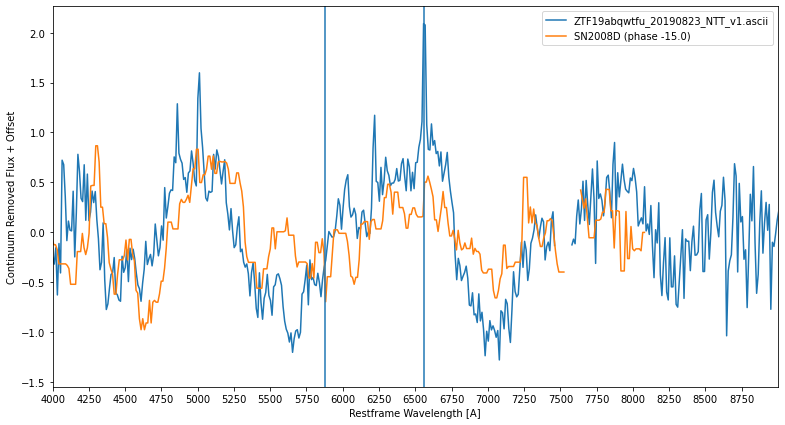

In [248]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 1, rebin=2, smooth=None, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '08d', 5, rebin=6, smooth=5, clip_telluric=True)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((4000, 9000))
ax.set_xticks(np.arange(4000, 9000, 250))
ax.axvline(5876)
ax.axvline(6562)

ax.legend()

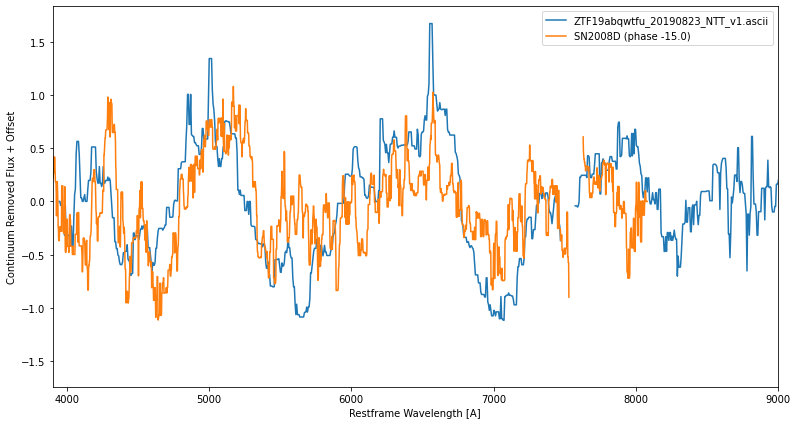

In [237]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 1, smooth=7, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '08d', 5, smooth=15, clip_telluric=True, offset=0)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((3900, 9000))

ax.legend()
fig.savefig('../paper/plots/specs/tmp_first_ntt_comparison_offset.png')

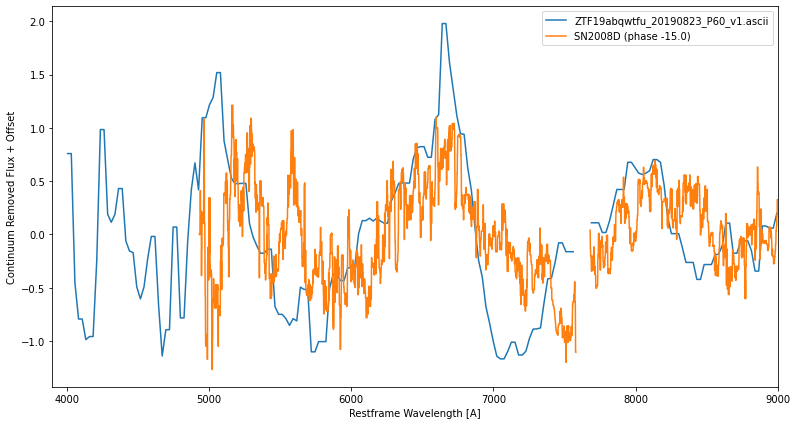

In [122]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 2, smooth=3, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '08d', 7, smooth=17, clip_telluric=True)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((3900, 9000))

ax.legend()

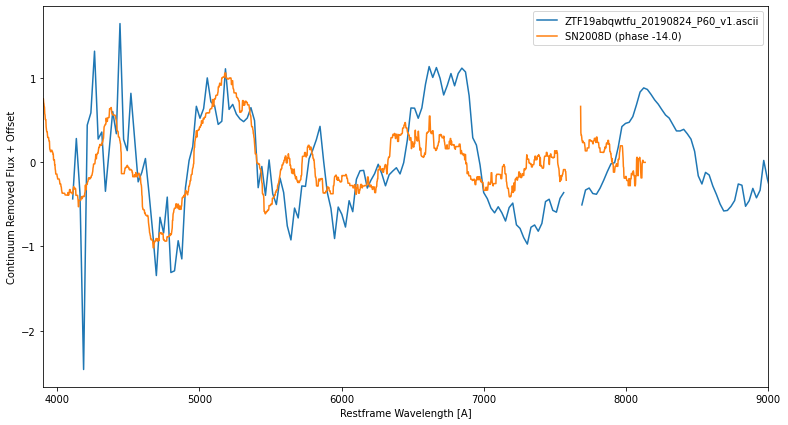

In [127]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 3, smooth=None, blue_cut=4100, clip_telluric=True)
plot_comparison(ax, '08d', 9, smooth=17, clip_telluric=True)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((3900, 9000))

ax.legend()

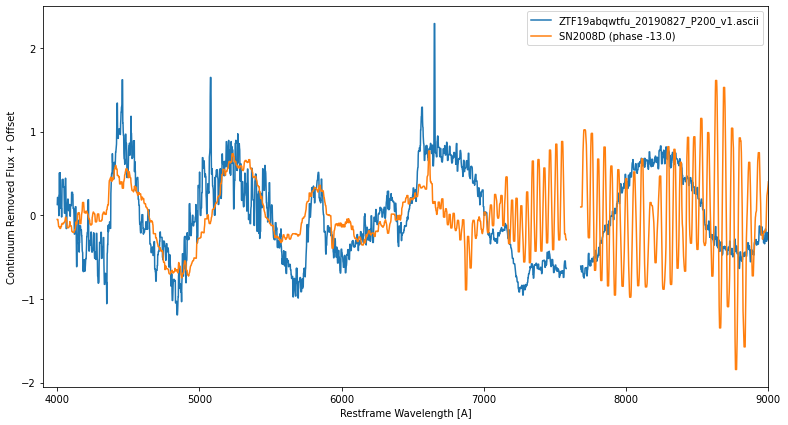

In [136]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 4, smooth=5, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '08d', 11, smooth=11, blue_cut=4000, clip_telluric=True)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((3900, 9000))

ax.legend()

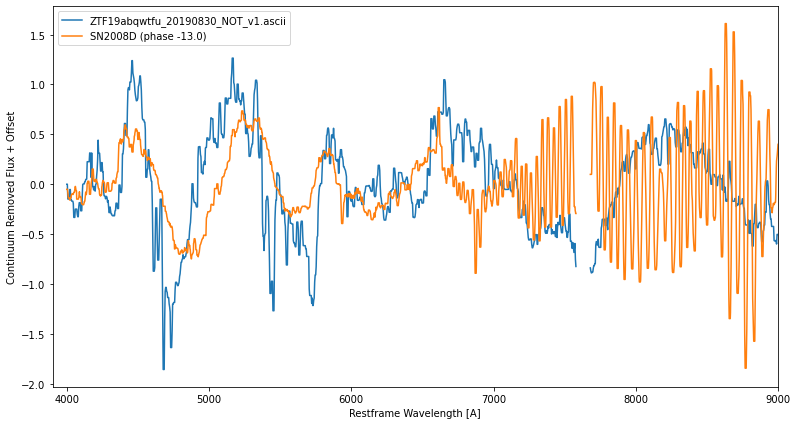

In [138]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 6, smooth=5, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '08d', 11, smooth=11, blue_cut=4000, clip_telluric=True)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((3900, 9000))

ax.legend()

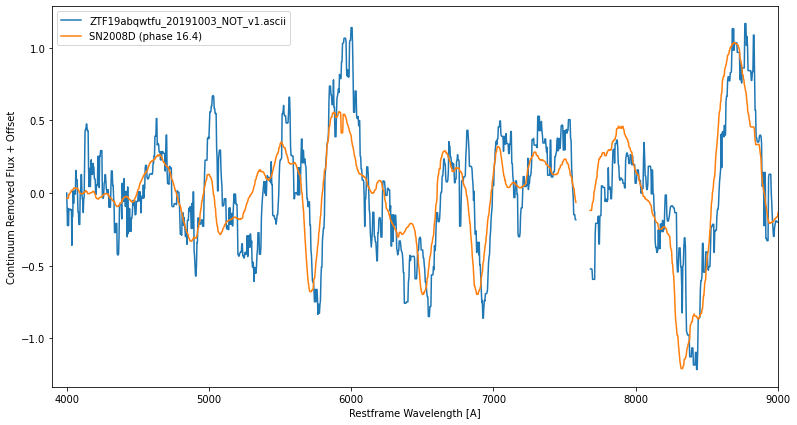

In [161]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 12, smooth=5, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '08d', 35, smooth=11, blue_cut=4000, clip_telluric=True)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((3900, 9000))

ax.legend()
fig.savefig('../paper/plots/specs/tmp_later_not_comparison.png')

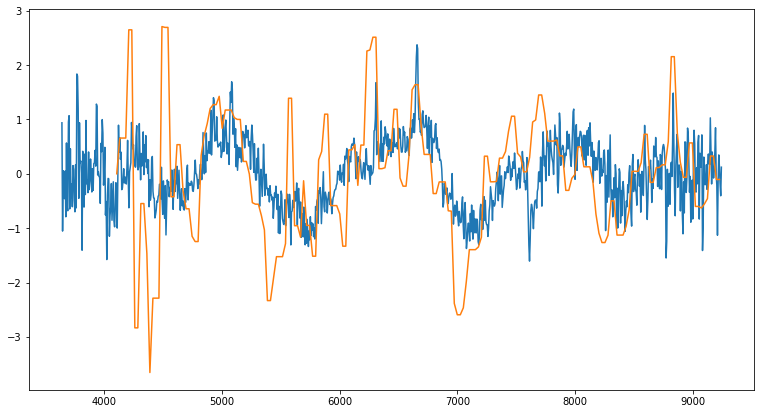

In [165]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 1, smooth=None)
plot_obs_spec(ax, 0, smooth=3, blue_cut=4100)

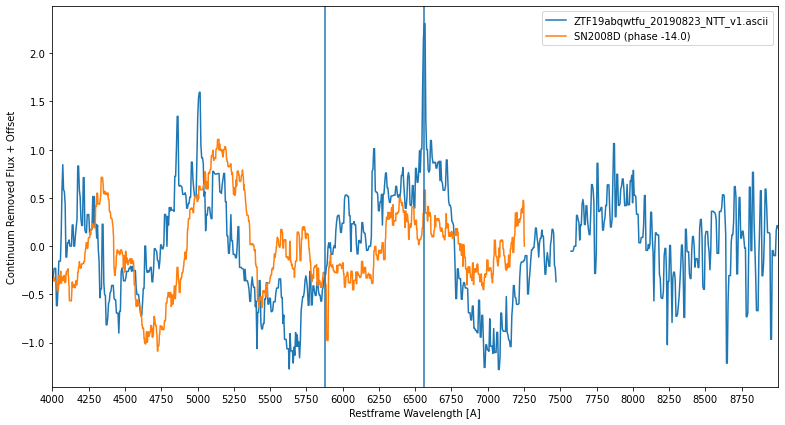

In [236]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)

plot_obs_spec(ax, 1, smooth=3, blue_cut=4000, clip_telluric=True)
plot_comparison(ax, '08d', 9, smooth=9, clip_telluric=True, red_cut=7300)

ax.set_xlabel('Restframe Wavelength [A]')
ax.set_ylabel('Continuum Removed Flux + Offset')
ax.set_xlim((4000, 9000))
ax.set_xticks(np.arange(4000, 9000, 250))
ax.axvline(5876)
ax.axvline(6562)

ax.legend()